In [1]:
import pandas as pd
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import pandas as pd
import matplotlib.pyplot as plt
    
#data 
data_normal = pd.read_parquet('data0.parquet')
data_attack = pd.read_parquet('test0.parquet')

# Get the organization name for an IP address
geo1=pygeoip.GeoIP('./GeoIP_DBs/GeoIP.dat')
geo2=pygeoip.GeoIP('./GeoIP_DBs/GeoIPASNum.dat')

def get_countryname(ip):
    return geo1.country_name_by_addr(ip)

# Verify if all ports are equal in data_normal vs data_attack
if (data_normal['port'].unique() != data_attack['port'].unique()).all():
    print("Different ports in data_normal vs data_attack")

# Verify if all protocols are equal in data_normal vs data_attack
if (data_normal['proto'].unique() != data_attack['proto'].unique()).all():
    print("Different protocols in data_normal vs data_attack")

# Put a label for each dst_ip with the country name
data_normal['dst_country'] = data_normal['dst_ip'].apply(get_countryname)
data_attack['dst_country'] = data_attack['dst_ip'].apply(get_countryname)

def timestamp_to_hour(timestamp):
    timestamp = timestamp/100
    hours, remainder = divmod(timestamp, 3600)
    minutes, seconds = divmod(remainder, 60)
    return "{:02}:{:02}:{:02}".format(int(hours), int(minutes), int(seconds))


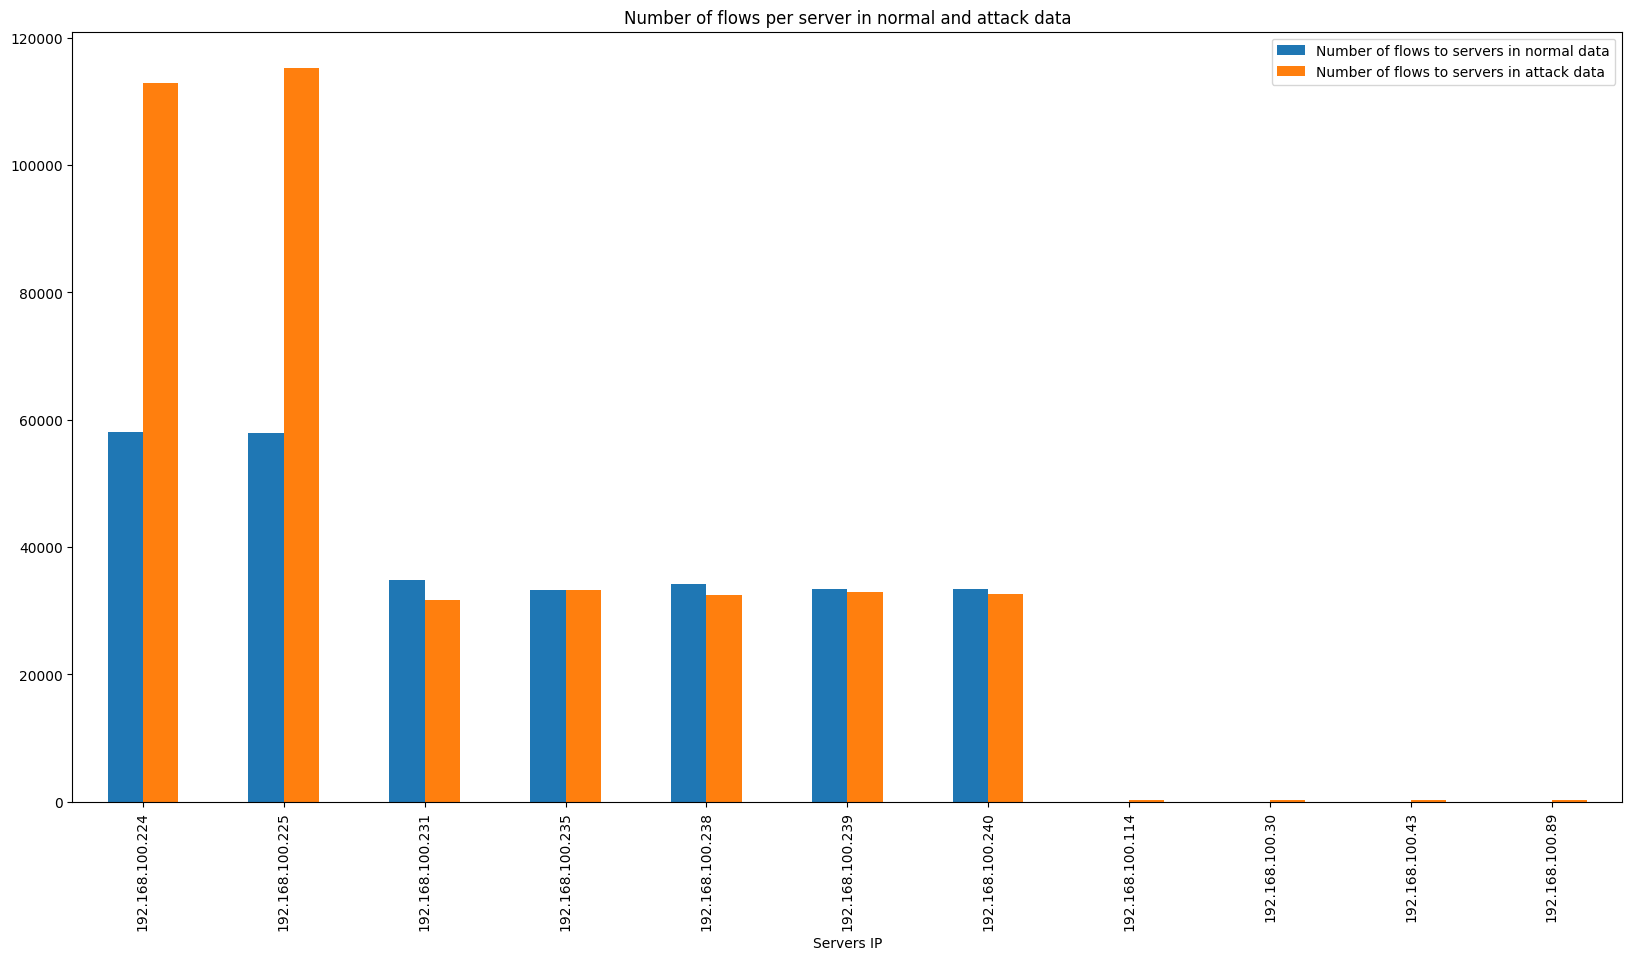

/tmp/ipykernel_6653/1847521510.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ip_192_168_100_114['timestamp'] = ip_192_168_100_114['timestamp'].apply(timestamp_to_hour)
/tmp/ipykernel_6653/1847521510.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ip_192_168_100_114['count'] = 1


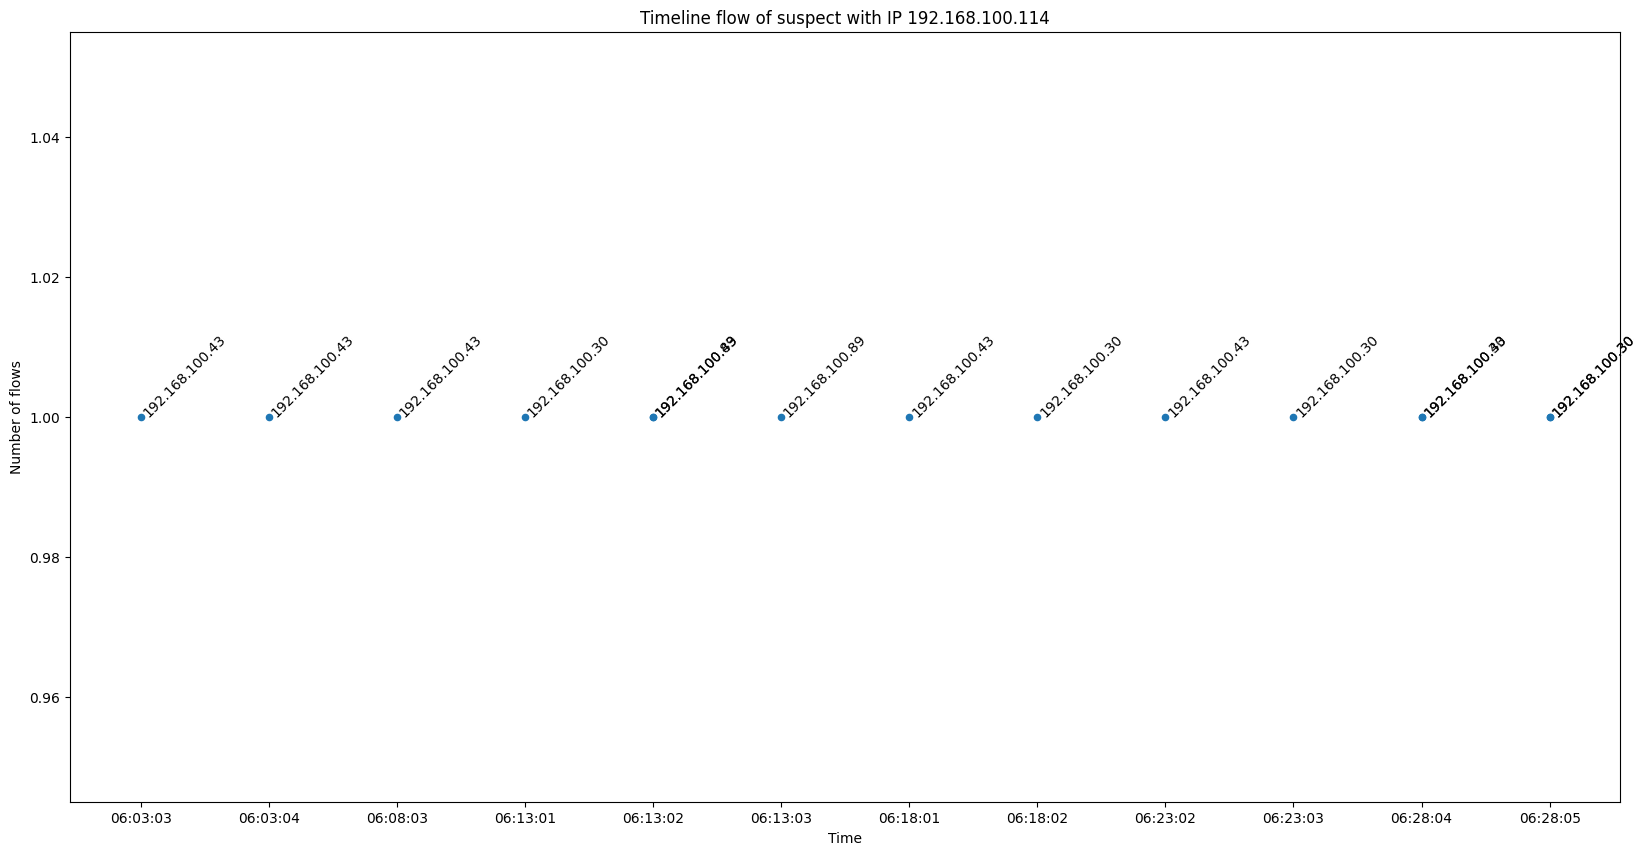

In [12]:
# POSSIBLE BOTNET

# ips com maior trafego TCP -> ips servirdores (normal e anomalo) -> diferenças de ips == botnet

# get private ips with more TCP traffic from data_normal both src_ip and dst_ip
server_ips_normal = data_normal.loc[((data_normal['src_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)) & (data_normal['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)))]
# get private ip 192.168.100.* as dst_ip with alot of TCP traffic from data_normal and count the number of flows
servers_normal = server_ips_normal.loc[(server_ips_normal['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)) & (server_ips_normal['dst_ip'].apply(lambda x: x.startswith('192.168.100.')))].groupby(['dst_ip']).size().reset_index(name='counts')

# get private ips with more TCP traffic from data_attack both src_ip and dst_ip
server_ips_attack = data_attack.loc[((data_attack['src_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)) & (data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)))]
# get private ip 192.168.100.* as dst_ip with alot of TCP traffic from data_attack and count the number of flows
servers_attack = server_ips_attack.loc[(server_ips_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)) & (server_ips_attack['dst_ip'].apply(lambda x: x.startswith('192.168.100.')))].groupby(['dst_ip']).size().reset_index(name='counts')

# get the difference between servers_normal and servers_attack
servers_attack = pd.merge(servers_normal, servers_attack, on=['dst_ip'], how='outer')

# get ips that have NaN in counts_normal 
botnet_suspects_flows = servers_attack[servers_attack['counts_x'].isnull()]

# fill NaN with 0
servers_attack = servers_attack.fillna(0)

#make a plot with the difference between servers_normal and servers_attack
servers_attack.plot(x='dst_ip', y=['counts_x', 'counts_y'], kind='bar', figsize=(20,10), title='Number of flows per server in normal and attack data')
# legend counts_x = Number of flows to servers in normal data, counts_y = Number of flows to servers in attack data
# rename counts_x and counts_y to flows_normal and flows_attack
# rename x axis to servers ip
plt.xlabel('Servers IP')
plt.legend(['Number of flows to servers in normal data', 'Number of flows to servers in attack data'])
plt.savefig('images/server_flows.png')
plt.show()

# new column with the % of difference between counts_normal and counts_attack
servers_attack['diff'] = (servers_attack['counts_y'] - servers_attack['counts_x']) / servers_attack['counts_x']
 

# check if there are communication between botnet_suspects ips and count the number of flows
botnet_suspects_flows = data_attack.loc[(data_attack['src_ip'].isin(botnet_suspects_flows['dst_ip'])) & (data_attack['dst_ip'].isin(botnet_suspects_flows['dst_ip']))].groupby(['src_ip','dst_ip']).size().reset_index(name='counts')

# get the protocol and port of the flows between botnet_suspects ips
botnet_suspects_flows = data_attack.loc[(data_attack['src_ip'].isin(botnet_suspects_flows['src_ip'])) & (data_attack['dst_ip'].isin(botnet_suspects_flows['dst_ip']))].groupby(['src_ip','dst_ip','proto','port']).size().reset_index(name='counts')

botnet_suspects_flows

# get the timelin from data_attack from ip 192.168.100.114 to the other botnet_suspects ips
ip_192_168_100_114 = data_attack.loc[(data_attack['src_ip'] == '192.168.100.114') & (data_attack['dst_ip'].isin(botnet_suspects_flows['dst_ip']))] 
# apply timestamp_to_hour to timestamp column
ip_192_168_100_114['timestamp'] = ip_192_168_100_114['timestamp'].apply(timestamp_to_hour)
# add a column named count with value 1
ip_192_168_100_114['count'] = 1

# show ip_192_168_100_114 but only the first 10 rows, src_ip, dst_ip, timestamp and remove index
ip_192_168_100_114[['src_ip','dst_ip','timestamp']].head(10).reset_index(drop=True)

# keep only the timestamp between 06:00:00 and 06:15:00
ip_192_168_100_114 = ip_192_168_100_114.loc[(ip_192_168_100_114['timestamp'] >= '06:00:00') & (ip_192_168_100_114['timestamp'] <= '06:30:00')]
# make plot with points
ip_192_168_100_114.plot(x='timestamp', y='count', kind='scatter', figsize=(20,10), title='Timeline flow of suspect with IP 192.168.100.114')
# to points add the dst_ip, make the dst_ip appear tilted
for i, txt in enumerate(ip_192_168_100_114['dst_ip']):
    plt.annotate(txt, (ip_192_168_100_114['timestamp'].iloc[i], ip_192_168_100_114['count'].iloc[i]), rotation=45)
#rename x axis to Time and y to Number of flows
plt.xlabel('Time')
plt.ylabel('Number of flows')
plt.savefig('images/timeline_bot.png')
plt.show()





Servers:
- 192.168.100.224 -> got 200% more flows than normal on data_attack why? Read next markdown
- 192.168.100.225 -> got 200% more flows than normal on data_attack why? Read next markdown
- 192.168.100.231
- 192.168.100.235
- 192.168.100.238
- 192.168.100.239
- 192.168.100.240

Botnet_suspect_ips:
- 192.168.100.114
- 192.168.100.30
- 192.168.100.43
- 192.168.100.89

They all communicate with each other on data_attack but not on data_normal

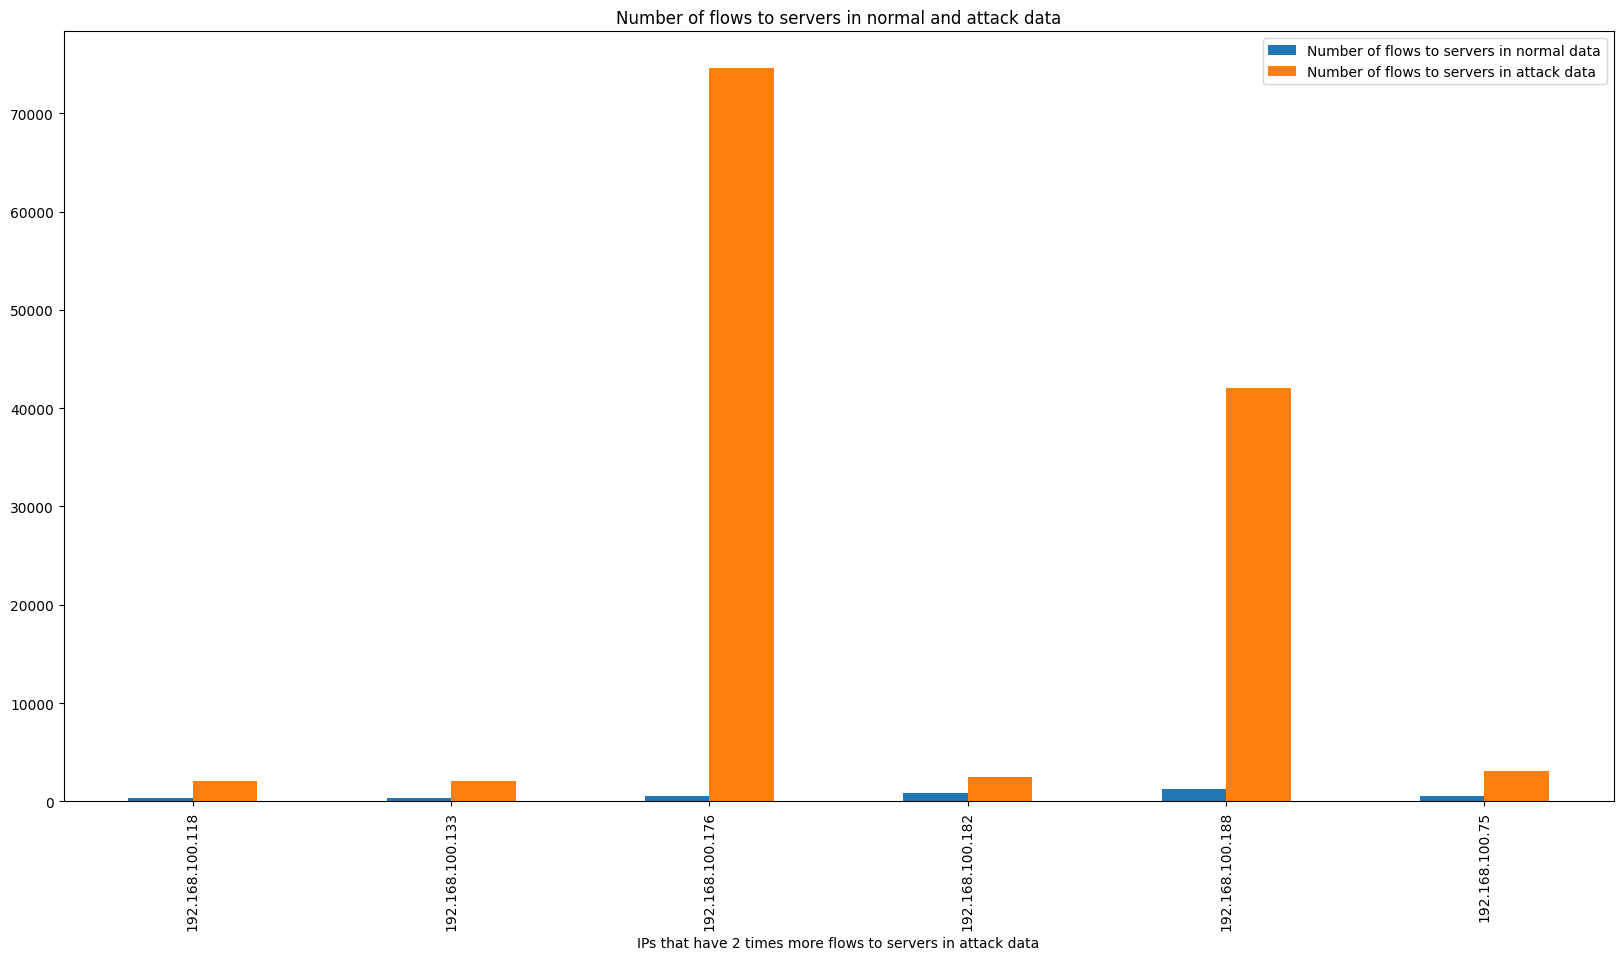

/tmp/ipykernel_6653/706346742.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ips_to_servers_attack['timestamp'] = ips_to_servers_attack['timestamp'].apply(timestamp_to_hour)


,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes,dst_country
index,,,,,,,,
436187,07:54:42,192.168.100.176,192.168.100.224,udp,53,178,391,
988489,07:54:42,192.168.100.176,192.168.100.225,udp,53,159,393,
436188,07:54:42,192.168.100.176,192.168.100.224,udp,53,170,447,
988490,07:54:42,192.168.100.176,192.168.100.225,udp,53,190,323,
436189,07:54:42,192.168.100.176,192.168.100.224,udp,53,178,373,
436190,07:54:42,192.168.100.176,192.168.100.224,udp,53,173,382,
988491,07:54:42,192.168.100.176,192.168.100.225,udp,53,182,358,
436191,07:54:42,192.168.100.176,192.168.100.224,udp,53,178,430,
988492,07:54:42,192.168.100.176,192.168.100.225,udp,53,178,371,


In [47]:
# Attack to Servers

# ON NORMAL DATA
# get ips with flows to servers and count the number of flows
ips_to_servers_normal = data_normal.loc[(data_normal['dst_ip'].isin(servers_normal['dst_ip']))].groupby(['src_ip']).size().reset_index(name='counts')

# ON ATTACK DATA
# get ips with flows to servers and count the number of flows
ips_to_servers_attack = data_attack.loc[(data_attack['dst_ip'].isin(servers_normal['dst_ip']))].groupby(['src_ip']).size().reset_index(name='counts')

# get the difference between ips_to_servers_normal and ips_to_servers_attack
ips_to_servers_attack = pd.merge(ips_to_servers_normal, ips_to_servers_attack, on=['src_ip'], how='outer')
# fill Nan with 0
ips_to_servers_attack = ips_to_servers_attack.fillna(0)
# calculate the rise of flows to servers in %
ips_to_servers_attack['rise'] = (ips_to_servers_attack['counts_y'] - ips_to_servers_attack['counts_x']) / ips_to_servers_attack['counts_x']

# keeo the ones with rise > 200% or rise is infinity and have more than 100 flows to servers in count_y
ips_to_servers_attack = ips_to_servers_attack[((ips_to_servers_attack['rise'] > 1.99) | (ips_to_servers_attack['rise'] == float('inf'))) & (ips_to_servers_attack['counts_y'] > 2000)]

# make bar plot with the count of flows to servers in normal and attack data
ips_to_servers_attack.plot(x='src_ip', y=['counts_x', 'counts_y'], kind='bar', figsize=(20,10), title='Number of flows to servers in normal and attack data')
# legend counts_x = Number of flows to servers in normal data, counts_y = Number of flows to servers in attack data
# rename counts_x and counts_y to flows_normal and flows_attack
# rename x axis to IPs that have 2 times more flows to servers in attack data
plt.xlabel('IPs that have 2 times more flows to servers in attack data')
plt.legend(['Number of flows to servers in normal data', 'Number of flows to servers in attack data'])
plt.savefig('images/ips_to_servers.png')
plt.show()

# keep the ones with rise > 5
ips_to_servers_attack = ips_to_servers_attack[ips_to_servers_attack['rise'] > 9.99]

# get the timeline for these ips in attack data
ips_to_servers_attack = data_attack.loc[(data_attack['src_ip'].isin(ips_to_servers_attack['src_ip']))]
# apply timestamp_to_hour to timestamp column
ips_to_servers_attack['timestamp'] = ips_to_servers_attack['timestamp'].apply(timestamp_to_hour)

# keep the first 20 rows
ips_to_servers_attack = ips_to_servers_attack.head(20)
# remove index
ips_to_servers_attack = ips_to_servers_attack.reset_index(drop=True)
# save ips_to_servers_attack to csv
ips_to_servers_attack.to_csv('images/timeline_C&C.csv', index=False)
ips_to_servers_attack




Attack to Servers:
- 192.168.100.176 
- 192.168.100.188

These IPs have 70k+ and 40k+ connections to servers respectively. A rise of 12736% and 3192% respectively compared to normal data.

They have a lot of flows to 192.168.100.224 and 192.168.100.225 which are servers. 

All these flows are with UDP protocol and port 53. This is some DNS attack.

They have udp packets with servers and then communicate with outside IPs with tcp on port 443.


In [ ]:
# SUSPECTS DOWNLOADING FROM INTERNET

# In normal data:
# get flows from private ips to internet and count the number of flows
download_normal = data_normal.loc[((data_normal['src_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)) & (data_normal['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False))].groupby(['src_ip','dst_ip']).size().reset_index(name='counts')
download_normal = download_normal[download_normal['counts'] > 100]

# In attack data:
# get flows from private ips to internet and count the number of flows
download_attack = data_attack.loc[((data_attack['src_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)) & (data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False))].groupby(['src_ip','dst_ip']).size().reset_index(name='counts')
download_attack = download_attack[download_attack['counts'] > 100]

# get the difference between download_normal and download_attack
download_attack = pd.merge(download_normal, download_attack, on=['src_ip','dst_ip'], how='right')

# calculate the rise of flows to servers in %
download_attack['rise'] = (download_attack['counts_y'] - download_attack['counts_x']) / download_attack['counts_x'] * 100

# keep the ones with rise > 200% or rise is infinity and have more than 100 flows to servers in count_y
download_attack = download_attack[((download_attack['rise'] > 200) | (download_attack['rise'] == float('inf'))) & (download_attack['counts_y'] > 100)]

# get down_bytes from pair src_ip and dst_ip in download_attack
download_attack_flows = data_attack.loc[(data_attack['src_ip'].isin(download_attack['src_ip'])) & (data_attack['dst_ip'].isin(download_attack['dst_ip']))].groupby(['src_ip','dst_ip'])['down_bytes'].sum().reset_index(name='down_bytes')

# merge download_attack_flows with download_attack
download_attack = pd.merge(download_attack, download_attack_flows, on=['src_ip','dst_ip'], how='outer')


IPs that generated 5x more private - private and private-public flows in data_attack than in data_normal:
- 192.168.100.75
- 192.168.100.118
- 192.168.100.129
- 192.168.100.133
- 192.168.100.163

They downloaded something from the internet

In [38]:
# EXFILTRATION?

# ON DATA NORMAL
# from the src_ip count the up_bytes to the internet
up_bytes_normal = data_normal.loc[(data_normal['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')
# from the src_ip count the number of flows to the internet
flows_normal = data_normal.loc[(data_normal['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['src_ip']).size().reset_index(name='flows')
# merge up_bytes and flows and get the average up_bytes per flow
up_bytes_normal = pd.merge(up_bytes_normal, flows_normal, on=['src_ip'], how='inner')
up_bytes_normal['up/flows'] = up_bytes_normal['up_bytes']/up_bytes_normal['flows']

# ON DATA ATTACK
# from the src_ip count the up_bytes to the internet
up_bytes_attack = data_attack.loc[(data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')
# from the src_ip count the number of flows to the internet
flows_attack = data_attack.loc[(data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['src_ip']).size().reset_index(name='flows')
# merge up_bytes and flows and get the average up_bytes per flow
up_bytes_attack = pd.merge(up_bytes_attack, flows_attack, on=['src_ip'], how='inner')
up_bytes_attack['up/flows'] = up_bytes_attack['up_bytes']/up_bytes_attack['flows']

# merge up_bytes_normal and up_bytes_attack and get the difference between up/flows and get the ones that have a 99% increase
up_bytes_diff = pd.merge(up_bytes_normal, up_bytes_attack, on=['src_ip'], how='inner')
up_bytes_diff = up_bytes_diff[(up_bytes_diff['up/flows_y'] > (up_bytes_diff['up/flows_x']*1.99))]

# get the dst_ip that have communication with the src_ip in up_bytes_diff and their org
exfiltration = data_attack.loc[(data_attack['src_ip'].isin(up_bytes_diff['src_ip'])) & (data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)]
exfiltration = exfiltration[['src_ip','dst_ip','timestamp']]
exfiltration['org'] = exfiltration['dst_ip'].apply(lambda x: geo2.org_by_addr(x))
exfiltration['timestamp'] = exfiltration['timestamp'].apply(timestamp_to_hour)
exfiltration['dst_country'] = exfiltration['dst_ip'].apply(get_countryname)

# from these src_ip get the up_bytes to the internet total from data_attack
up_bytes_stat = data_attack.loc[(data_attack['src_ip'].isin(exfiltration['src_ip'])) & (data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_exfiltration')
# from these src_ip get the up_bytes to the internet total from data_normal
up_bytes_stat['up_normal'] = data_normal.loc[(data_normal['src_ip'].isin(exfiltration['src_ip'])) & (data_normal['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_normal')['up_normal']
# new column with the difference between up_exfiltration and up_normal in percentage
up_bytes_stat['diff'] = (up_bytes_stat['up_exfiltration'] - up_bytes_stat['up_normal'])/up_bytes_stat['up_normal']*100

# keep the ones that transmitted more than 1GB
up_bytes_stat_1gb = up_bytes_stat[up_bytes_stat['up_exfiltration'] > 1000000000]

# get to know the dst_ip that have communication with the src_ip in up_bytes_stat and their org and dns
exfiltration_stat = data_attack.loc[(data_attack['src_ip'].isin(up_bytes_stat_1gb['src_ip'])) & (data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)]

# group by src_ip and dst_ip and count the number of flows
exfiltration_stat = exfiltration_stat.groupby(['src_ip','dst_ip']).size().reset_index(name='counts')
# from the data_attack get the up_bytes from the src_ip and dst_ip -> src_ip, dst_ip, up_bytes
get_up_bytes = data_attack.loc[(data_attack['src_ip'].isin(exfiltration_stat['src_ip'])) & (data_attack['dst_ip'].isin(exfiltration_stat['dst_ip']))].groupby(['src_ip','dst_ip'])['up_bytes'].sum().reset_index(name='up_bytes')
# merge get_up_bytes with exfiltration_stat
exfiltration_stat = pd.merge(exfiltration_stat, get_up_bytes, on=['src_ip','dst_ip'], how='inner')



# keep the ones that have more than 1GB
exfiltration_stat = exfiltration_stat[exfiltration_stat['up_bytes'] > 1000000000]
# get their org 
exfiltration_stat['org'] = exfiltration_stat['dst_ip'].apply(lambda x: geo2.org_by_addr(x))
# get their country
exfiltration_stat['dst_country'] = exfiltration_stat['dst_ip'].apply(get_countryname)

These IPs comunicate with the internet got 2x up_bytes/flows in data_attack than in data_normal:
- 192.168.100.194
- 192.168.100.145
- 192.168.100.112
- 192.168.100.121
- 192.168.100.29
- 192.168.100.23

Even tought they happen in 'normal' hours, it's still suspicious, looking futher into it:
- 192.168.100.194 up_bytes rised by   356.2895661238 % in data_attack
- 192.168.100.145 up_bytes rised by    21.282723578  % in data_attack
- 192.168.100.112 up_bytes rised by 21857.1962912547 % in data_attack
- 192.168.100.121 up_bytes rised by 16006.5805975834 % in data_attack
- 192.168.100.29  up_bytes rised by  7171.1105271715 % in data_attack
- 192.168.100.23  up_bytes rised by   359.4208205681 % in data_attack

Only 3 updated more than 1Gb:
- 192.168.100.112
- 192.168.100.121
- 192.168.100.29

Very possible case of exfiltration
The following IPs where receiving that data:
- 142.250.184.184 - AS15169 GOOGLE
- 13.107.42.39    - AS8068 MICROSOFT-CORP-MSN-AS-BLOCK
- 13.107.42.27    - AS8068 MICROSOFT-CORP-MSN-AS-BLOCK

The IPs all belong to the USA, helps explain why USA has more down_bytes in data_attack than in data_normal

In [43]:
# plot up_bytes_normal vs up_bytes_attack in a bar plot
# just for the ips in up_bytes_stat
up_bytes_stat_plot = pd.merge(up_bytes_normal, up_bytes_attack, on=['src_ip'], how='inner')
up_bytes_stat_plot = up_bytes_stat_plot[up_bytes_stat_plot['src_ip'].isin(up_bytes_stat['src_ip'])]
up_bytes_stat_plot = up_bytes_stat_plot[['src_ip','up/flows_x','up/flows_y']]
up_bytes_stat_plot = up_bytes_stat_plot.set_index('src_ip')
# change legend names
up_bytes_stat_plot = up_bytes_stat_plot.rename(columns={'up/flows_x': 'up/flows_normal', 'up/flows_y': 'up/flows_attack'})
up_bytes_stat_plot.plot.bar(figsize=(20,10), title='Up Bytes per Flow', rot=0)
# rename x axis to Suspect IPs and y to Bytes
plt.ylabel('Bytes')
plt.xlabel('Suspect IPs')
# save figure as png
plt.savefig('images/up_bytes.png')
plt.close()



# plot the how much bytes was tranmitted with ips in up_bytes_stat
up_bytes_stat_plot = up_bytes_stat[['src_ip','up_exfiltration']]
up_bytes_stat_plot = up_bytes_stat_plot.set_index('src_ip')
up_bytes_stat_plot.plot.bar(figsize=(20,10), title='Uploaded Bytes to Public IPs', rot=0)
# save figure as png
# rename x axis to Suspect IPs and y to Bytes
plt.ylabel('Bytes')
plt.xlabel('Suspect IPs')
plt.savefig('images/up_bytes_exfiltration.png')
plt.close()

exfiltration_stat
# save exfiltration_stat to csv
exfiltration_stat.to_csv('images/exfiltration_stat.csv', index=False)


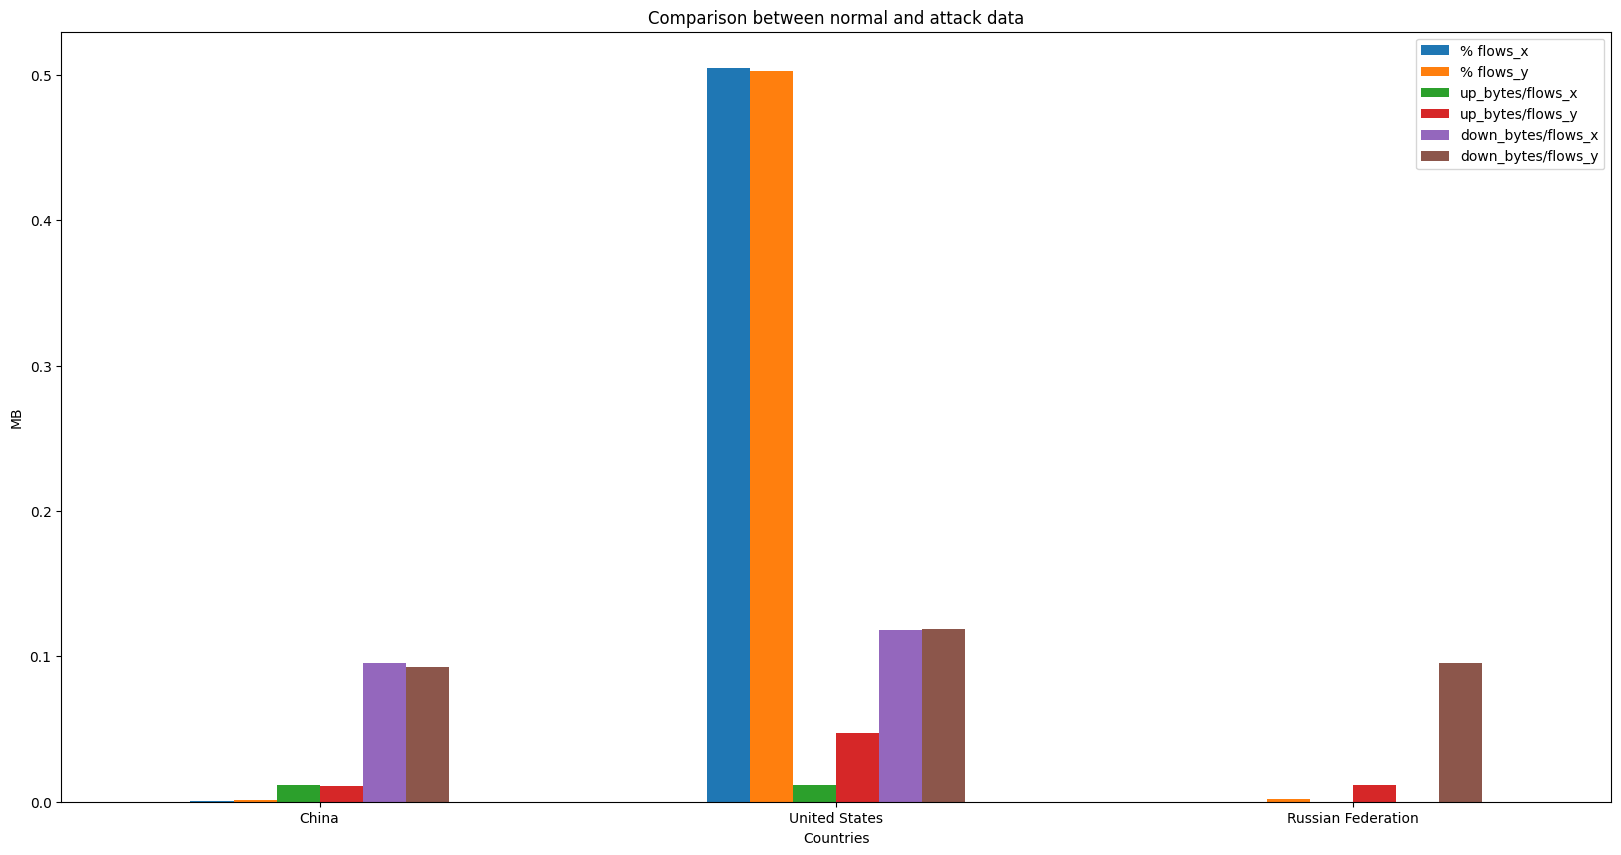

In [46]:
# COUNTRY STATISTICS

# ON DATA NORMAL
# get the number of flows has destination to each country
normal_country = data_normal.loc[(data_normal['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['dst_country']).size().reset_index(name='flows_to_country')
# get the number of up_bytes has destination to each country
normal_country['up_bytes'] = data_normal.loc[(data_normal['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['dst_country'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']
# get the number of down_bytes has destination to each country
normal_country['down_bytes'] = data_normal.loc[(data_normal['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['dst_country'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']


# make a mean between the number of flows to each country
normal_country['% flows'] = normal_country['flows_to_country']/normal_country['flows_to_country'].sum()
# make the mean between the up_bytes of one country and the flows to that country
normal_country['up_bytes/flows'] = normal_country['up_bytes']/normal_country['flows_to_country']
# make the mean between the down_bytes of one country and the flows to that country
normal_country['down_bytes/flows'] = normal_country['down_bytes']/normal_country['flows_to_country']

# ON DATA ATTACK
# get the number of flows has destination to each country
attack_country = data_attack.loc[(data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['dst_country']).size().reset_index(name='flows_to_country')
# get the number of up_bytes has destination to each country
attack_country['up_bytes'] = data_attack.loc[(data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['dst_country'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']
# get the number of down_bytes has destination to each country
attack_country['down_bytes'] = data_attack.loc[(data_attack['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['dst_country'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']

# make a mean between the number of flows to each country
attack_country['% flows'] = attack_country['flows_to_country']/attack_country['flows_to_country'].sum()
# make the mean between the up_bytes of one country and the flows to that country
attack_country['up_bytes/flows'] = attack_country['up_bytes']/attack_country['flows_to_country']
# make the mean between the down_bytes of one country and the flows to that country
attack_country['down_bytes/flows'] = attack_country['down_bytes']/attack_country['flows_to_country']

# merge normal_country and attack_country and get the difference between % flows, up_bytes/flows and down_bytes/flows and get the ones that have a 99% increase and more than 100 flows
country_diff = pd.merge(normal_country, attack_country, on=['dst_country'], how='outer')
# substitute Nan with 0
country_diff = country_diff.fillna(0)
country_diff = country_diff[((country_diff['% flows_y'] > (country_diff['% flows_x']*4.99)) | (country_diff['up_bytes/flows_y'] > (country_diff['up_bytes/flows_x']*1.99)) | (country_diff['down_bytes/flows_y'] > (country_diff['down_bytes/flows_x']*1.99))) & (country_diff['flows_to_country_y'] > 100)]

# compare all x with all y make it a % rise
country_diff['% flows rise'] = (country_diff['% flows_y'] - country_diff['% flows_x']) / country_diff['% flows_x']
country_diff['up_bytes/flows rise'] = (country_diff['up_bytes/flows_y'] - country_diff['up_bytes/flows_x']) / country_diff['up_bytes/flows_x']
country_diff['down_bytes/flows rise'] = (country_diff['down_bytes/flows_y'] - country_diff['down_bytes/flows_x']) / country_diff['down_bytes/flows_x'] 

# change all bytes to MB
country_diff['up_bytes/flows_x'] = country_diff['up_bytes/flows_x']/1000000
country_diff['up_bytes/flows_y'] = country_diff['up_bytes/flows_y']/1000000
country_diff['down_bytes/flows_x'] = country_diff['down_bytes/flows_x']/1000000
country_diff['down_bytes/flows_y'] = country_diff['down_bytes/flows_y']/1000000

# make plot compare the x and y of every column
country_diff_plot = country_diff[['dst_country','% flows_x','% flows_y','up_bytes/flows_x','up_bytes/flows_y','down_bytes/flows_x','down_bytes/flows_y']]
country_diff_plot = country_diff_plot.set_index('dst_country')
country_diff_plot.plot.bar(figsize=(20,10), title='Comparison between normal and attack data', rot=0)
# rename x axis to Countries and y to Bytes
plt.ylabel('MB')
plt.xlabel('Countries')
# save figure as png
plt.savefig('images/country_diff.png')




Countries:
- China -> more than 5x more flows in data_attack than in data_normal, but up_bytes/flows and down_bytes/flows are similar between data_attack and data_normal
- Russia -> it didn't happen in data_normal, but it happened in data_attack
- USA -> alot more up_bytes and down_bytes in data_attack than in data_normal

In [ ]:
# TIME STATISTICS

# ON DATA NORMAL
# get src_ip and its min timestamp and max timestamp
normal_time  = data_normal.groupby(['src_ip'])['timestamp'].agg(['min','max']).reset_index()

# get the mean min timestamp and max timestamp between all src_ip
mean_min_time = normal_time['min'].mean()
mean_max_time = normal_time['max'].mean()

# ON DATA ATTACK
start_work = 7
end_work = 22
# get the src_ip and its min timestamp and max timestamp
attack_time  = data_attack.groupby(['src_ip'])['timestamp'].agg(['min','max']).reset_index()
attack_time['min'] = attack_time['min'].apply(timestamp_to_hour)
attack_time['max'] = attack_time['max'].apply(timestamp_to_hour)

# keep the ones that min_time is before 7:00:00 or max_time is after 22:00:00
attack_time = attack_time[((attack_time['min'] < '07:00:00') | (attack_time['max'] > '22:00:00'))]

# get number of total flows from data_attack
attack_time['flows_anomaly'] = data_attack.groupby(['src_ip']).size().reset_index(name='flows')['flows']
# get number of total flows from data_normal
attack_time['flows_normal'] = data_normal.groupby(['src_ip']).size().reset_index(name='flows')['flows']
# get the % of increase of flows
attack_time['flows_rise'] = (attack_time['flows_anomaly'] - attack_time['flows_normal'])/attack_time['flows_normal']

# get number of total up_bytes from data_attack
attack_time['up_bytes_anomaly'] = data_attack.groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']
# get up_bytes per flow from data_attack
attack_time['up_bytes/flows_anomaly'] = attack_time['up_bytes_anomaly']/attack_time['flows_anomaly']
# get number of total up_bytes from data_normal
attack_time['up_bytes_normal'] = data_normal.groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']
# get up_bytes per flow from data_normal
attack_time['up_bytes/flows_normal'] = attack_time['up_bytes_normal']/attack_time['flows_normal']
# get the % of increase of up_bytes/flows
attack_time['up_bytes_rise'] = (attack_time['up_bytes/flows_anomaly'] - attack_time['up_bytes/flows_normal'])/attack_time['up_bytes/flows_normal']

# get number of total down_bytes from data_attack
attack_time['down_bytes_anomaly'] = data_attack.groupby(['src_ip'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']
# get down_bytes per flow from data_attack
attack_time['down_bytes/flows_anomaly'] = attack_time['down_bytes_anomaly']/attack_time['flows_anomaly']
# get number of total down_bytes from data_normal
attack_time['down_bytes_normal'] = data_normal.groupby(['src_ip'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']
# get down_bytes per flow from data_normal
attack_time['down_bytes/flows_normal'] = attack_time['down_bytes_normal']/attack_time['flows_normal']
# get the % of increase of down_bytes/flows
attack_time['down_bytes_rise'] = (attack_time['down_bytes/flows_anomaly'] - attack_time['down_bytes/flows_normal'])/attack_time['down_bytes/flows_normal']

# keep the ones with flows_rise > 100% or up_bytes_rise > 50% or down_bytes_rise > 50%
attack_time = attack_time[((attack_time['flows_rise'] > 1) | (attack_time['up_bytes_rise'] > 0.5) | (attack_time['down_bytes_rise'] > 0.5))]

# get all flows from ip 192.168.100.23 in data_attack
ip_192_168_100_23 = data_attack.loc[(data_attack['src_ip']=='192.168.100.23')]
# timestamp to hour
ip_192_168_100_23['timestamp'] = ip_192_168_100_23['timestamp'].apply(timestamp_to_hour)
# get org from dst_ip
ip_192_168_100_23['org'] = ip_192_168_100_23['dst_ip'].apply(lambda x: geo2.org_by_addr(x))
# get the down_bytes total of the ip
ip_192_168_100_23['down_bytes'] = ip_192_168_100_23.groupby(['src_ip'])['down_bytes'].transform('sum')
# get the up_bytes total of the ip
ip_192_168_100_23['up_bytes'] = ip_192_168_100_23.groupby(['src_ip'])['up_bytes'].transform('sum')
# get the down_bytes of org
ip_192_168_100_23['down_bytes_org'] = ip_192_168_100_23.groupby(['org'])['down_bytes'].transform('sum')
# get the up_bytes of org
ip_192_168_100_23['up_bytes_org'] = ip_192_168_100_23.groupby(['org'])['up_bytes'].transform('sum')

# get all flows from ip 192.168.100.59 in data_attack
ip_192_168_100_59 = data_attack.loc[(data_attack['src_ip']=='192.168.100.59')]
# timestamp to hour
ip_192_168_100_59['timestamp'] = ip_192_168_100_59['timestamp'].apply(timestamp_to_hour)
# get org from dst_ip
ip_192_168_100_59['org'] = ip_192_168_100_59['dst_ip'].apply(lambda x: geo2.org_by_addr(x))
# get the down_bytes total of the ip
ip_192_168_100_59['down_bytes'] = ip_192_168_100_59.groupby(['src_ip'])['down_bytes'].transform('sum')
# get the up_bytes total of the ip
ip_192_168_100_59['up_bytes'] = ip_192_168_100_59.groupby(['src_ip'])['up_bytes'].transform('sum')
# get the down_bytes of org
ip_192_168_100_59['down_bytes_org'] = ip_192_168_100_59.groupby(['org'])['down_bytes'].transform('sum')
# get the up_bytes of org
ip_192_168_100_59['up_bytes_org'] = ip_192_168_100_59.groupby(['org'])['up_bytes'].transform('sum')

# get all flows from ip 192.168.100.181
ip_192_168_100_181 = data_attack.loc[(data_attack['src_ip']=='192.168.100.181')]
# timestamp to hour
ip_192_168_100_181['timestamp'] = ip_192_168_100_181['timestamp'].apply(timestamp_to_hour)
# get org from dst_ip
ip_192_168_100_181['org'] = ip_192_168_100_181['dst_ip'].apply(lambda x: geo2.org_by_addr(x))
# get the down_bytes total of the ip
ip_192_168_100_181['down_bytes'] = ip_192_168_100_181.groupby(['src_ip'])['down_bytes'].transform('sum')
# get the up_bytes total of the ip
ip_192_168_100_181['up_bytes'] = ip_192_168_100_181.groupby(['src_ip'])['up_bytes'].transform('sum')
# get the down_bytes of org
ip_192_168_100_181['down_bytes_org'] = ip_192_168_100_181.groupby(['org'])['down_bytes'].transform('sum')
# get the up_bytes of org
ip_192_168_100_181['up_bytes_org'] = ip_192_168_100_181.groupby(['org'])['up_bytes'].transform('sum')

# get all flows from ip 192.168.100.118
ip_192_168_100_118 = data_attack.loc[(data_attack['src_ip']=='192.168.100.118')]
# timestamp to hour
ip_192_168_100_118['timestamp'] = ip_192_168_100_118['timestamp'].apply(timestamp_to_hour)
# get org from dst_ip
ip_192_168_100_118['org'] = ip_192_168_100_118['dst_ip'].apply(lambda x: geo2.org_by_addr(x))
# get the down_bytes total of the ip
ip_192_168_100_118['down_bytes'] = ip_192_168_100_118.groupby(['src_ip'])['down_bytes'].transform('sum')
# get the up_bytes total of the ip
ip_192_168_100_118['up_bytes'] = ip_192_168_100_118.groupby(['src_ip'])['up_bytes'].transform('sum')
# get the down_bytes of org
ip_192_168_100_118['down_bytes_org'] = ip_192_168_100_118.groupby(['org'])['down_bytes'].transform('sum')
# get the up_bytes of org
ip_192_168_100_118['up_bytes_org'] = ip_192_168_100_118.groupby(['org'])['up_bytes'].transform('sum')

The ip 192.168.100.23 has flows starting at 6:11, suspicious, looking futher into it:
- The flows occur with almost no time between them, bot like behaviour
- These early flows are with the servers, and then it starts communicating with the internet

Same behaviour for the rest of ips are somewhat alike (.23, .59, .181, .118)

